# Обучение нейросетей — оптимизация и регуляризация


В этой домашке надо реализовать Dropout-слой и проследить его влияние на обобщающую способность сети

## Dropout

Как всегда будем экспериментировать на датасете MNIST. MNIST является стандартным бенчмарк-датасетом, и его можно подгрузить средствами pytorch.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    torch.use_deterministic_algorithms(True)

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
need_run_tests_and_training = 'google.colab' in str(get_ipython())
need_run_tests_and_training

True

In [5]:
input_size = 784
num_classes = 10
batch_size = 128

train_dataset = dsets.MNIST(root='./MNIST/',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.MNIST(root='./MNIST/',
                                  train=False,
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 545kB/s]


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.30MB/s]


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Определим ряд стандартных функций с прошлых семинаров

In [6]:
def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        data = x_batch
        target = y_batch

        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)

        loss = F.nll_loss(output, target).cpu()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        data = x_batch
        target = y_batch

        output = model(data)
        loss = F.nll_loss(output, target).cpu()

        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)

        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)

    points = np.array(val_history)

    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()

def train(model, opt, n_epochs):

    if not need_run_tests_and_training:
        return

    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batch_size)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)
        plot_history(train_acc_log, val_acc_log, title='accuracy')

        print("Epoch: {2}, val loss: {0}, val accuracy: {1}".format(np.mean(val_loss), np.mean(val_acc), epoch))


Создайте простейшую однослойную модель - однослойную полносвязную сеть и обучите ее с параметрами оптимизации, заданными ниже.

**nn.Flatten(1)**

Этот слой "выравнивает" (flattens) входные данные, начиная с указанной размерности. В данном случае 1 означает, что все измерения, начиная с первого (индексация с нуля), будут объединены в одно измерение.

Например, если входные данные имеют форму (batch_size, channels, height, width), то после применения Flatten(1) они превратятся в (batch_size, channels * height * width).

Это полезно, когда вы хотите преобразовать многомерные данные (например, изображения) в одномерный вектор для передачи в полносвязный слой.

**nn.Linear(input_size, num_classes)**

Это полносвязный (линейный) слой, который выполняет линейное преобразование входных данных.

input_size — это размер входного вектора (количество входных признаков).

num_classes — это количество выходных нейронов, которое обычно соответствует количеству классов в задаче классификации.

Формула, которую применяет этот слой:

y
=
x
⋅
W
T
+
b
y=x⋅W
T
 +b
где:

x
x — входной вектор,

W
W — матрица весов,

b
b — вектор смещений (bias),

y
y — выходной вектор.

In [7]:
#nn.Sequential - контейнер, который позволяет последовательно объединять слои нейронной сети.
#Данные будут проходить через каждый слой в том порядке, в котором они указаны.
model = nn.Sequential(
                    nn.Flatten(1),
                    nn.Linear(input_size, num_classes),
                    nn.LogSoftmax(dim=-1)
)

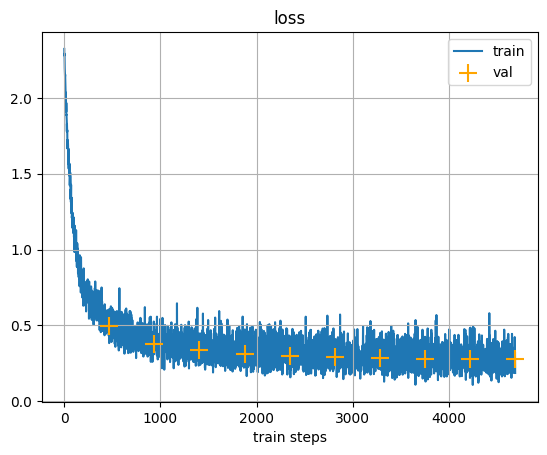

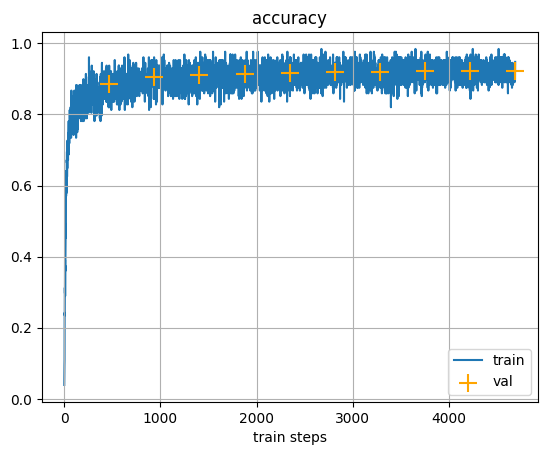

Epoch: 9, val loss: 0.27559400022124186, val accuracy: 0.9220727682113647


In [8]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(model, opt, 10)

Параметром обученной нейросети является матрица весов, в которой каждому классу соответствует один из 784-мерных столбцов. Визуализируйте обученные векторы для каждого из классов, сделав их двумерными изображениями 28-28. Для визуализации можно воспользоваться кодом для визуализации MNIST-картинок с предыдущих семинаров.

In [9]:
model._modules['1'].weight.shape

torch.Size([10, 784])

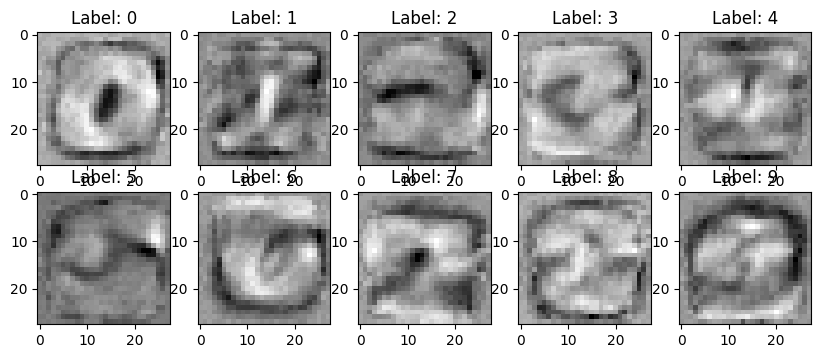

In [10]:
weights = model._modules['1'].weight.detach().numpy()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)

    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Реализуйте Dropout-слой для полносвязной сети. Помните, что этот слой ведет себя по-разному во время обучения и во время применения.

In [13]:
# эту ячейку в тестах я буду сохранять в отдельный файл, поэтому не нужно
# изменять имя класса, убирать импорты (добавлять, в принципе, можно)
# добавлять в ячейку какой-то посторонний код, не связанный с реализацией этого класса

import torch
import torch.nn as nn
import torch.nn.functional as F


class DropoutLayer(nn.Module): # не надо переименовыввать этот класс
    """
    https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
    """
    def __init__(self, p=0.5, inplace=False):
        super().__init__()
        self.p = p
        self.inplace = inplace

    def forward(self, input):

        # todo
        # подсказка: скорее всего, вам понадобится ф-я rand_like https://pytorch.org/docs/stable/generated/torch.rand_like.html
        # и masked_fill_ https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html

        if self.training:
          mask = torch.rand_like(input) > self.p
          if self.inplace:
            input.masked_fill_(~mask,0)
            return input
          else:
            return input * mask.float() / (1 - self.p)
        else:
            return input


In [14]:
from tqdm.auto import tqdm

def test_dropout_train():

    zero_proba = 0.9
    do = DropoutLayer(p=zero_proba, inplace=False)

    assert do.p == zero_proba, f"zero_proba is ok"

    do.train()

    input_tensor = torch.rand( (7, 3, 28, 28) )
    input_tensor_clone = input_tensor.clone()

    dropouted_tensor = do(input_tensor)

    assert (input_tensor_clone == input_tensor).all(), "input tensor was not changed"

    zeroed_values = (dropouted_tensor == 0).sum()
    # print("input_tensor.numel()", input_tensor.numel())
    expected_zeroed_values = input_tensor.numel() * do.p

    assert (zeroed_values - expected_zeroed_values).abs() < 200, f"zeroed_values={zeroed_values} expected_zeroed_values={expected_zeroed_values}"

    input_module = input_tensor.abs().sum()
    output_module = dropouted_tensor.abs().sum()
    module_diff = (input_module - output_module).abs()
    assert module_diff < 1000, f"input_norm {input_module}, outout_norm {output_module}, diff={module_diff}"

def test_dropout_eval():

    with torch.no_grad():

        zero_proba = 0.9
        do = DropoutLayer(p=zero_proba, inplace=False)

        assert do.p == zero_proba, f"zero_proba is ok"

        do.eval()

        input_tensor = torch.rand( (7, 3, 28, 28) )
        input_tensor_clone = input_tensor.clone()

        dropouted_tensor = do(input_tensor)

        assert (input_tensor_clone == input_tensor).all(), "input tensor was not changed"
        assert (dropouted_tensor == input_tensor_clone).all(), "output tensor equals to input"

seed_everything(42)

if need_run_tests_and_training:
    for _ in tqdm(range(100)):
        test_dropout_train()
        test_dropout_eval()

  0%|          | 0/100 [00:00<?, ?it/s]

Добавьте Dropout-слой в архитектуру сети, проведите оптимизацию с параметрами, заданными ранее, визуализируйте обученные веса. Есть ли разница между весами обученными с Dropout и без него? Параметр Dropout возьмите равным 0.7

In [15]:
modelDp = nn.Sequential(
                    nn.Flatten(1),
                    DropoutLayer(p=0.7),
                    nn.Linear(28 * 28, 10),
                    nn.LogSoftmax(dim=-1)
    )

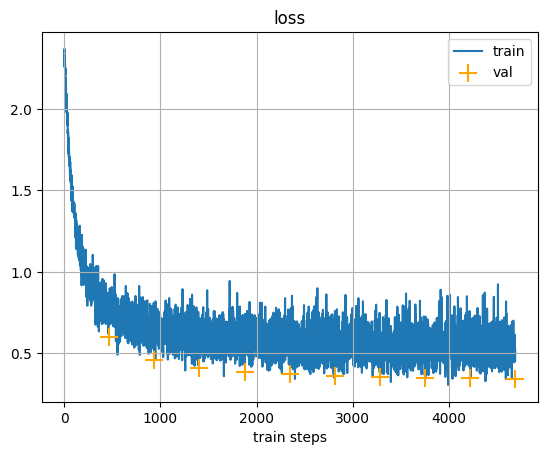

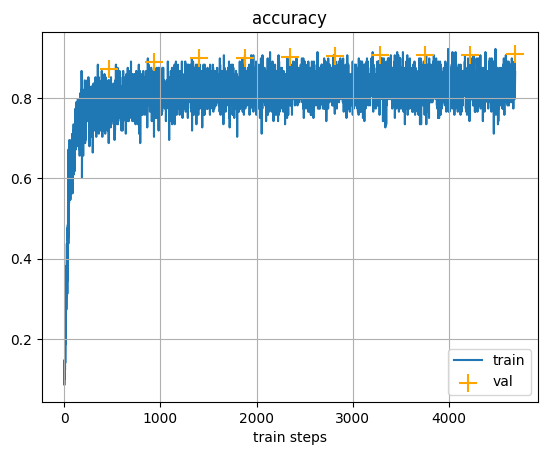

Epoch: 9, val loss: 0.3452822593854198, val accuracy: 0.908030092716217


In [16]:
opt = torch.optim.Adam(modelDp.parameters(), lr=0.0005)
train(modelDp, opt, 10)

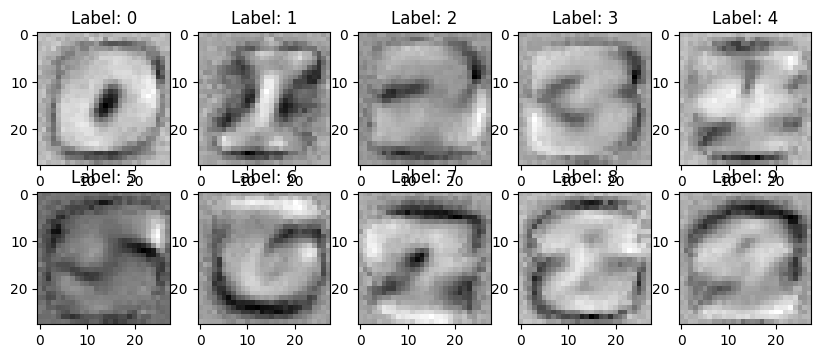

In [17]:
weights = modelDp._modules['2'].weight.detach().numpy()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Обучите еще одну модель, в которой вместо Dropout-регуляризации используется L2-регуляризация с коэффициентом 0.05. (Параметр weight_decay в оптимизаторе). Визуализируйте веса и сравните с двумя предыдущими подходами.

In [18]:
model = nn.Sequential(
    nn.Flatten(1),
    nn.Linear(input_size,num_classes),
    nn.LogSoftmax(dim=-1)
    )

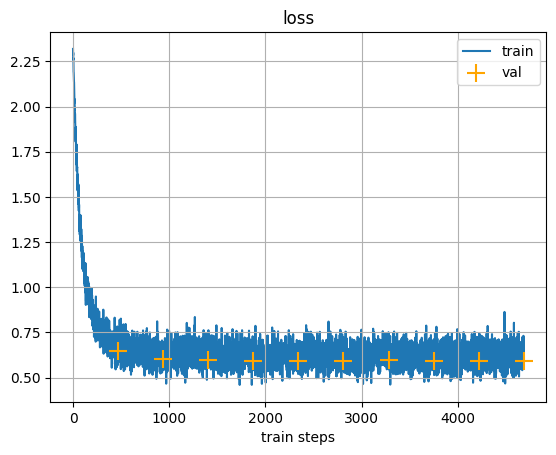

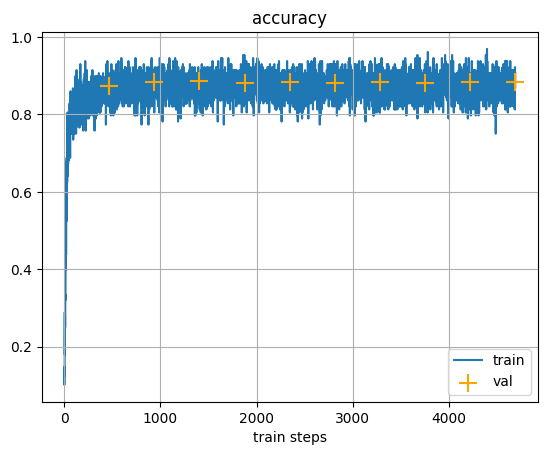

Epoch: 9, val loss: 0.5926975323052346, val accuracy: 0.884592592716217


In [19]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.05)
train(model, opt, 10)

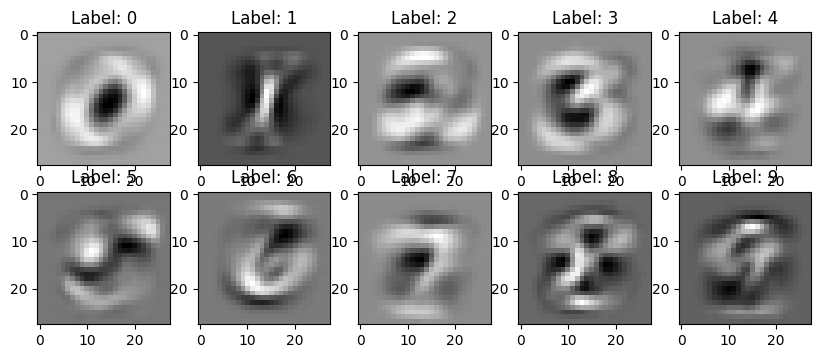

In [20]:
weights = model._modules['1'].weight.detach().numpy()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');